In [23]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available: 0


In [24]:
with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"].values
X_val   = data["X_val"].values
X_test  = data["X_test"].values
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]
test_dates = data["test_dates"]
scaler  = data["scaler"]
yscaler = data["scaler_y"]

y_test.shape

(213661,)

In [26]:
sequence_length = 5

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, sequence_length)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, sequence_length)


print(X_train_seq.min(), X_train_seq.max(), X_train_seq.std())
print(y_train_seq.min(), y_train_seq.max(), y_train_seq.std())


0.0 1.0000000000000002 0.22992918157100303
0.0 1.0 0.2056241659137077


In [27]:


model = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [28]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

class PredictionHistory(Callback):
    def __init__(self, X_train_seq, y_train_seq, y_scaler):
        super().__init__()
        self.X_train_seq = X_train_seq
        self.y_train_seq = y_train_seq
        self.y_scaler = y_scaler
        self.predictions_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict on the training set
        pred_scaled = self.model.predict(self.X_train_seq, verbose=0)
        pred_inv = self.y_scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
        self.predictions_per_epoch.append(pred_inv)

        # Compute RMSE for monitoring
        actual = self.y_scaler.inverse_transform(self.y_train_seq.reshape(-1,1)).flatten()
        rmse = np.sqrt(np.mean((actual - pred_inv)**2))
        print(f"Epoch {epoch+1} - Train RMSE: {rmse:.4f}")


Epoch 1/2
31112/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239Epoch 1 - Train RMSE: 0.9179
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 0.0214 - val_loss: 0.0390
Epoch 2/2
31144/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188Epoch 2 - Train RMSE: 0.9011
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 0.0183 - val_loss: 0.0378


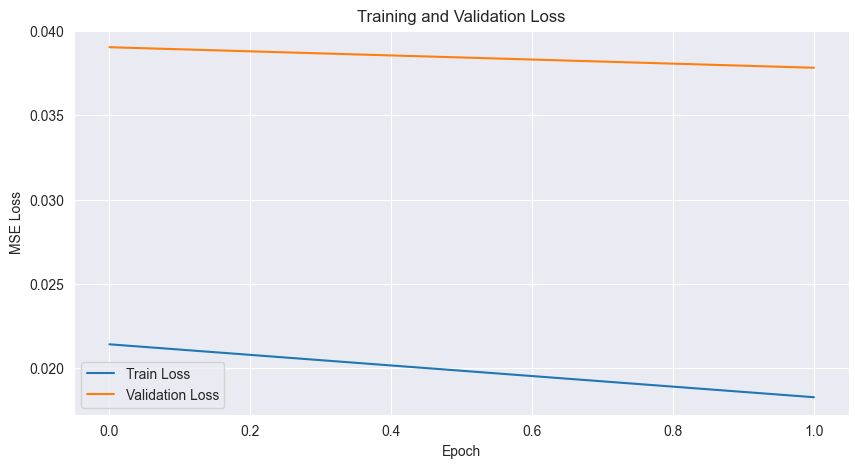

In [29]:

callback = PredictionHistory(X_train_seq, y_train_seq, y_scaler)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=2,
    batch_size=32,
    shuffle=False,
    callbacks=[callback]
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


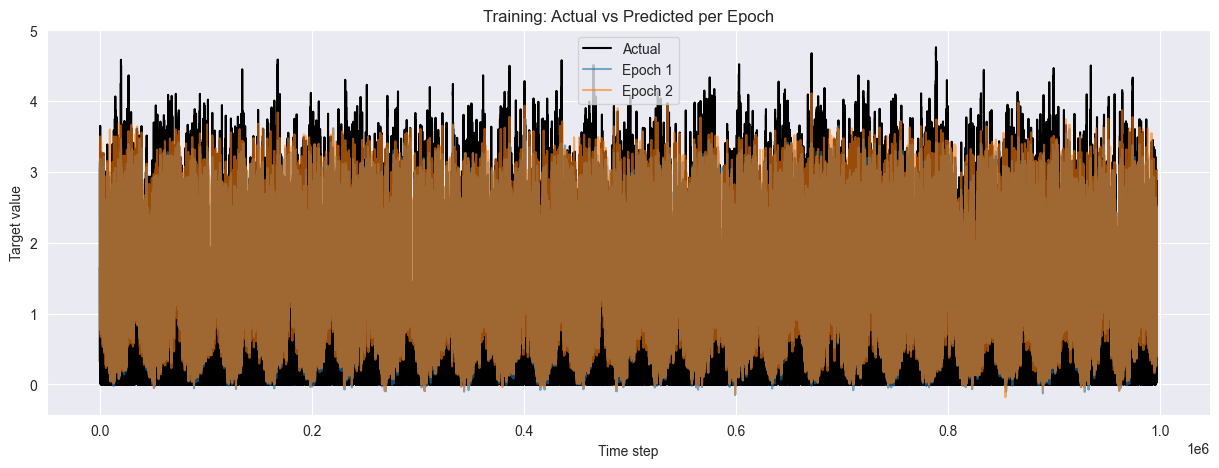

In [30]:
actual = y_scaler.inverse_transform(y_train_seq.reshape(-1,1)).flatten()

plt.figure(figsize=(15,5))
plt.plot(actual, label="Actual", color='black')

# Plot predictions for each epoch
for i, pred in enumerate(callback.predictions_per_epoch):
    plt.plot(pred, label=f"Epoch {i+1}", alpha=0.6)

plt.xlabel("Time step")
plt.ylabel("Target value")
plt.title("Training: Actual vs Predicted per Epoch")
plt.legend()
plt.show()


In [31]:
pred_scaled = model.predict(X_test_seq)

print(pred_scaled)
print(X_test_seq)
# Inverse scale both prediction and ground truth
pred = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
print(actual.min(), actual.max(), actual.std())

# Compute RMSE
rmse = np.sqrt(np.mean((actual - pred)**2))
print(f"RMSE: {rmse:.4f}")

6677/6677 ━━━━━━━━━━━━━━━━━━━━ 4s 662us/step
[[0.11594477]
 [0.10339892]
 [0.08716394]
 ...
 [0.3138036 ]
 [0.28838485]
 [0.31421196]]
[[[0.51757188 0.45529801 0.43066884 ... 0.36170213 0.37837838 0.29832936]
  [0.50638978 0.46688742 0.43882545 ... 0.46808511 0.43243243 0.30310263]
  [0.5543131  0.51821192 0.49918434 ... 0.53191489 0.43243243 0.31264916]
  [0.49680511 0.4718543  0.46655791 ... 0.38297872 0.35135135 0.31742243]
  [0.54632588 0.52980132 0.51712887 ... 0.5106383  0.43243243 0.33293556]]

 [[0.50638978 0.46688742 0.43882545 ... 0.46808511 0.43243243 0.30310263]
  [0.5543131  0.51821192 0.49918434 ... 0.53191489 0.43243243 0.31264916]
  [0.49680511 0.4718543  0.46655791 ... 0.38297872 0.35135135 0.31742243]
  [0.54632588 0.52980132 0.51712887 ... 0.5106383  0.43243243 0.33293556]
  [0.59105431 0.56622517 0.57096248 ... 0.53191489 0.43243243 0.33770883]]

 [[0.5543131  0.51821192 0.49918434 ... 0.53191489 0.43243243 0.31264916]
  [0.49680511 0.4718543  0.46655791 ... 0.38297

[0.55211943 0.49237713 0.4150675  ... 1.4943069  1.3732649  1.4962515 ]


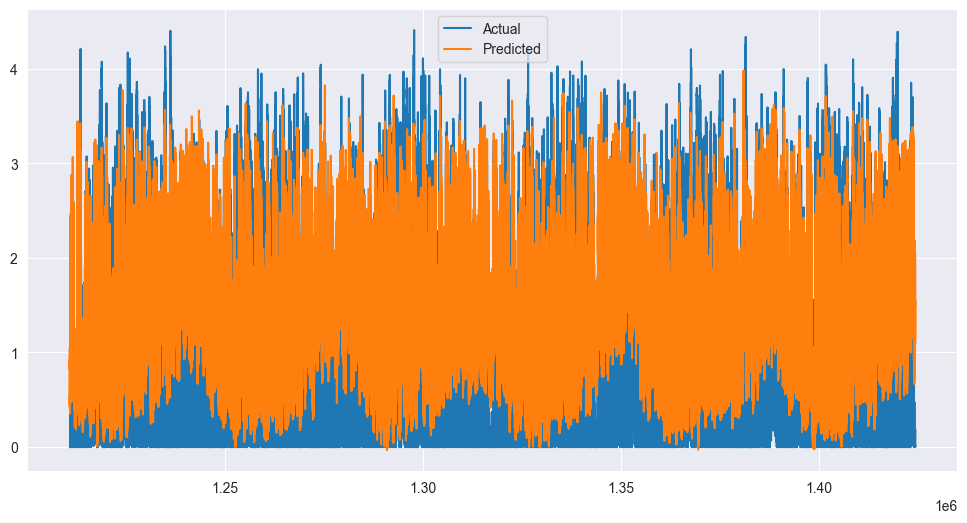

In [32]:
print(pred)
plt.figure(figsize=(12, 6))
plt.plot(test_dates[sequence_length:], actual, label='Actual')
plt.plot(test_dates[sequence_length:], pred, label='Predicted')
plt.legend()
plt.grid(True)
plt.show()

